## Recurrent Neural Networks

## The basic RNN Cell

RNN cells incorporate this dependence by having a hidden state, or memory, that holds the essence of what has been seen so far. The value of the hidden state at any point in time is a function of the value of the hidden state at the previous time step, and the value of the input at the current time step, that is :  
  
$$h_t = \phi(h_{t-1}, X_t)$$
  
Here, $h_t$ and $h_{t-1}$ are the values of the hidden states at the time $t$ and $t-1$ respectively, and $x_t$ is the value of the input at time $t$. Notice that the equation is recursive, that is, $h_{t-1}$ can be represented in terms of $h_{t-2}$ and $x_{t-1}$, and so on, until the beginning of the sequence. This is how RNNs encode and incorporate information from arbitrarily long sequences.  
  
Just as in a traditional neural network, where the learned parameters are stored as weight matrices, the RNN's parameters are defined by the three weight matrices $U$, $V$, and $W$, corresponding to the weight of the input, output, and hidden states respectively.  
  
Note that the weight matrices $U$, $V$, and $W$, that we spoke about earlier, are shared between each of the time steps. This is because we are applying the same operation to different inputs at each time step. Being able to share these weights across all the time steps greatly reduce the number of parameters that the RNN needs to learn.  
  
We can also describe the RNN as a computation graph in terms of equations. The internal state of the RNN at a time $t$ is given by the value of the hidden vector $h(t)$, which is the sum of the weight matrix $W$ and the hidden state $h_{t-1}$ at time $t-1$, and the product of the weight matrix $U$ and the input $x_t$ at time $t$, passed through a **`than`** activation function. The choice of **`than`** over other activation functions such as sigmoid has to do with it being more effieicnt for learning in practice, and helps combat the vanishing gradient problem.  
  
The output vector $y_t$ at time $t$ is the product of the weight matrix $V$ and the hidden state $h_t$, passed through a softmax activation, such that the resulting vector is a set of output probalities:
  
$$h_t = than(Wh_{t-1} + Ux_t)$$
$$y_t = softmax(Vh_t)$$
  
Keras provides the SimpleRNN recurrent layer that incorporates all the logic we have seen so far, as well as the more advanced variants such as LSTM and GRU.

## Backpropagation through time (BPTT)

Just like traditional neural networks, training RNNs also invloves backpropagation of gradients. The difference in this case is that since the weights are shared by all time steps, the gradient at each output depends not only on the current time step, but also on the previous ones. This process is called backpropagation through time. Because the weights $U$, $V$, and $W$, are shared across the different time steps in case of RNNs, we need to sum up the gradients across the various time steps in case of BPTT. This is the key differnece between traditional backpropagation and BPTT.  
  
Consider the RNN with five time steps shown in *Figure* 2. During the forward pass, the network produces predictions $\hat y_t$ at time $t$ that are compared with the label $y_t$ to compute a loss $L_t$. During backpropagation (shown by the dotted lines), the gradients of the loss with respect to the weights $U$, $V$, and $W$, are computed at each time step and the parameters updated with the sum of the gradients:

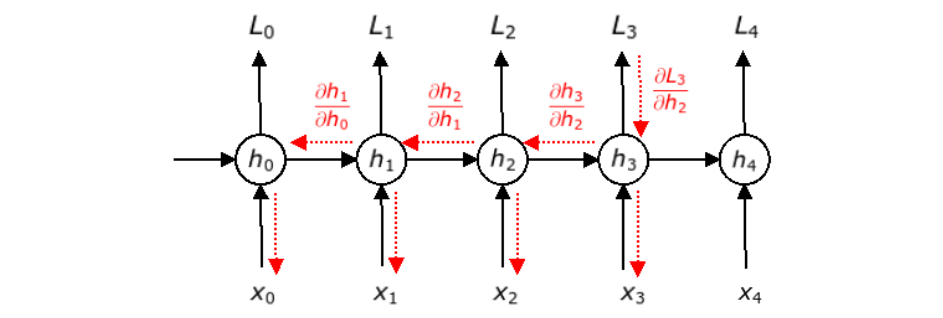

<center>Figure 2 : Backpropagation through time

THe following equation shows the gradient of the loss with respect to $W$. We focus on this weight because it is the cause for the phenomenon known as the vanishing and exploding gradient problem.  
  
This problem manifests as the gradients of the loss approaching either zero or infinity, making the network hard to train. To understand why this happens, consider the equation of the SimpleRNN we was earlier; the hidden state $h_t$ is dependent on $h_{t-1}$, which is turn is dependent on $h_{t-2}$, and so on:
  

$$\frac {\partial L}{\partial W} = \sum_t \frac {\partial L_t}{\partial W}$$

Let us know see what happens to this gradient at timestep $t=3$. By the chain rule, the gradient of the loss with respect to $W$ can be decomposed to a product of three sub-gradients. The gradient of the hidden state $h_2$ with respect to $W$ can be further decomposed as the sum of the gradient of each hidden state with respect to the previous one. Finally, each gradient of the hidden state with respect to previous one can be further decomposed as the product of gradients of the current hidden state against the previous hidden state:

$$ \frac {\partial L_3}{\partial W} = 
\frac {\partial L_3}{\partial \hat y_3} 
\frac {\partial \hat y_3}{\partial h_3}
\frac {\partial h_3}{\partial W}
\\
= \sum_{t=0}^3 
\frac {\partial L_3}{\partial \hat y_3}
\frac {\partial \hat y_3}{\partial h_3} 
\frac {\partial h_3}{\partial h_t}
\frac {\partial h_t}{\partial W}
\\
\sum_{t=0}^3 
\frac {\partial L_3}{\partial \hat y_3} 
\frac {\partial \hat y_3}{\partial \hat h_3}
(\prod_{j=t+1}^3 
\frac {\partial h_j}{\partial h_{h-1}})
\frac {\partial h_t}{\partial W}
$$

Similar calculations are done to compute the gradient of the other losses $L_0$ through $L_4$ with respect to $W$, and sum them up into the gradient update for $W$. We will not explore the math further in this book, but this WildML blog post (http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/) has a very good explanation of BPTT, including a more detailed derivation of the math behind the process.

### Vanishing and exploding gradients

The reason BERT is particularly sensitive to the problem of vanishing and exploding gradients comes from the product part of the expression representing the final formulation of the gradient of the loss with respect to $W$. Consider the case where the individual gradients of a hidden state with respect to the previous one is less then 1.  
  
As we backpropaget across multiple time steps, the product of gradients get smaller and smaller, ultimately leading to the problem of vanishing gradients. Similarly, if the gradients are larger than 1, the products get larger and larger, and ultimately lead to the problem of exploding gradients.  
  
of the two, exploding gradients are more easily detectable. The gradients will become very large and turn into **Not a number (NaN)** and the training process will crash. Exploding gradients can be controlled by clipping them at a predefined threshold. TensorFlow 2.0 allows you to clip gradients using the **`clipvalue`** or **`clipnorm`** parameter during optimizer construction, or by explicitly clipping gradients using **`tf.clip_by_value`**.  
  
The effect of vanishing gradients is that gradients from time steps that are far away do not contribute anything to the learning process, so the RNN ends up not learning any long-range dependencies. While there are a few approaches to minimizing the problem, such as proper initialization of the $W$ matrix, more aggressive regularization, using ReLU instead of **`than`** activation, and pretraining the layers using unsupervised methods, the most popular solution is to use LSTM or GRU architectures, each of which will be explained shortly. These architectures have been designed to deal with vanishing gradients and learn long-term dependencies more effectively.

## RNN Cell variants

### Long short-term memory (LSTM)

The LSTM is a variant of the SimpleRNN cell that is capable of learning long-term dependencies. We have seen how the SimpleRNN combines the hidden state from the previous time step and the current input through a tanh layer to implement recurrence. LSTMs also implement recurrence in a similar way, but instead of a simgle **`than`** layer, there are four layers interacting in very specific way.The following diagram illustrates the transformations that are applied in the hidden state at time step $t$.  
  
The diagram looks complicated, but let us look at it component by component. The line across the top of the diagram is the cell state $c$, representing the internal memory of the unit.  
  
The line across the bottom is the hidden state $h$, and the $i$, $f$, $o$ and $g$ gates are the mechanisms by which the LSTM works around the vanishing gradient problem. During training, the LSTM learns the parameters for these gates:

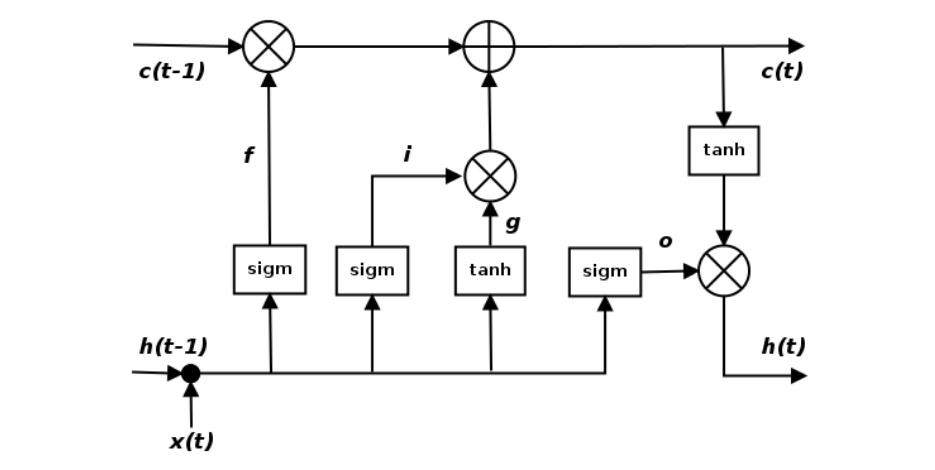

An alternative way to think about how these gates work inside and LSTM cell is to consider the equations for the cell. These equations describe how the value of the hidden state $h_t$ at time $t$ is calculated from the value of hidden state $h_{t-1}$ at the previous time step.

The set of equations representing an LSTM are shown as follows:  
  
$$i = \sigma (W_i h_{t-1} + U_i x_t + V_i c_{t-1})\\
f = \sigma (W_f h_{t-1} + U_f x_t + V_f c_{t-1})\\
o = \sigma (W_o h_{t-1} + U_o x_t + V_o c_{t-1})\\
g = tanh(W_g h_{t-1} + U_g x_t)\\
c_t = (f * c_{t-1}) + (g * i)\\
h_t = tanh(c_t) * o
$$
  
Here $i$, $f$, and $o$ are the input, forget, and output gates. They are computed using the same equations but with different parameter matrices $W_i$, $U_i$, $W_f$, $U_f$, and $W_o$, $U_o$. The sigmoid function modulates the output of these gates between 0 and 1, so the output vectors produced can be multipled element-wise with another vector to define how much of the second vector can pass through the first one.  
  
The forget gate defines how much of the previous state $h_{t-1}$ you want to allow to pass through. The input gate defines how much of the newly computed state for the current input $x_t$ you want to let through, and the output gate defines how much of the internal state you want to expose to the next layer. The internal hidden state $g$ is computed based on the current input $x_t$ and the previous hidden state $h_{t-1}$. Notice that the equation for $g$ is identical to that for the SimpleRNN, except that in this case we will modulate the output by the output of input vector $i$.  
  
Given $i$, $f$, $o$, and $g$, we can now calculate the cell state $c_t$ at time $t$ as the cell state $c_{t-1}$ at time ($t-1$) multiplied by the value of the forget gate $f$, plus the state $g$ multiplied by the input gate $i$. This is basically a way to combine the previous memory and the new input - setting the forget gate to 0 ignores the old memory and setting the input gate to 0 ignores the newly computed state. Finally, the hidden state $h_t$ at time $t$ is computed as the memory $c_t$ at time $t$, with the output gate $o$.  
  
If you would like to learn more about LSTMs, please take a look at the WildML RNN tutorial(http://www.wildml.com/2015/10/recurrent-neural-network-tutorial-part-4-implementing-a-grulstm-rnn-with-python-and-theano/) and Christopher Olah's blog post(https://colah.github.io/posts/2015-08-Understanding-LSTMs/). The first covers LSTM in somewhat greater detail and the second takes you step by step through the computations in a very visual way.

### Gated recurrent unit (GRU)

The GRU is a variant of the LSTM and was introduced by Cho, et al. It retains the LSTM's resistance to the vanishing gradient problem, but its internal structure is simpler, and is therefore faster to train, since less computations are needed to make updates to its hidden state.  
  
Instead of the input ($i$), forgot ($f$), and output ($o$) gates in the LSTM cell, the GRU cell has two gates, an update gate $z$ and a reset gate $r$. The update gate defines how much previous memory to keep around, and the reset gate defines how to combine the new input with the previous memory. There is no persistent cell state distinct from the hidden state as it is in LSTM.  
  
The GRU cell defines the computation of the hidden state $h_t$ at time $t$ from the hidden state $h_{t-1}$ at the previous time step using the following set of equations:  
  
$$z = \sigma (W_z h_{t-1} + U_z x_t)\\
r = \sigma (W_r h_{t-1} + U_r x_t)\\
c = tanh(W_c (h_{t-1} * r) + U_c x_t)\\
h_t = (z * c) + ((1-z) * h_{t-1})$$  
  
The outputs of the update gate $z$ and the reset gate $r$ are both computed using a combination of the previous hidden state $h_{t-1}$ and the current input $x_t$. The sigmoid function modulates the output of these functions between 0 and 1. The cell state $c$ is computed as a function of the output of the reset gate $r$ and input $x_t$. Finally, the hidden state $h_t$ at time $t$ is computed as a function of the cell state $c$ and the previous hidden state $h_{t-1}$. The parameters $W_z$, $U_z$, $W_r$, $U_r$, and $W_c$, $U_c$ are learned during training.  

### Peephole LSTM

The peephole LSTM is an LSTM variant. It adds "peepholes" to the input, forget, and output gates, so they can see the previous cell state $c_{t-1}$.

## RNN variants

In this section, we will look at a couple of variations on the basic RNN architecture that can provide performance improvements in some specific circumstances. Note that these strategies can be applied for different kinds of RNN cells, as well as for different RNN topologies, which we will learn about later.

### Bidirectional RNNs

We have seen how, at any given time step $t$, the output of the RNN is dependent on the outputs all previous time steps. However, it is entirely possible that the output is also dependent on the future outputs as well. This is especially true for applications such as natural language processing where the attributes of the word or phrase we are trying to predict may be dependent on the context given by the entire enclosing sentence, not just the words that came before it.  
  
This problem can be solved using a bidirectional LSTM, which are essentially two RNNs stacked on top of each other, one reading the input from left to right, and the other reading the input from the right to the left. The output at each time step will be based on the hidden state of both RNNs. Bidirectional RNNs allow the network to place equal emphasis on the beginning and end of the sequence, and typically results in performance improvements.

### Stateful RNNs

RNNs can also be stateful, which means that they can maintain state across batches during training. That is, the hidden state computed for a batch of training data will be used as the initial hidden state for the next batch of training data. Setting an RNN to be stateful means that it can build state across its training sequence and even maintain that state when doing predictions. The benefits of using stateful RNNs are smaller network size and/or lower training times. The disadvantage is that we are now reponsible for training the network with a batch size that reflects the periodicity of the data and resetting the state after each epoch. In addition, data should not be shuffled while training the network since the order in which the data is presented is relevant for stateful networks.  
  
To set a RNN layer as stateful, set the named variable stateful to **`True`**. In our example of a one-to-many topology for learning to generate text, we provide an example of using a stateful RNN. Here, we train using data consisting of contiguous text slices, so setting the LSTM to stateful means that the hidden state generated from the previous text chunk is reused for the current text chunk.

## RNN topologies

We have seen examples of how MLP and CNN architectures can be composed to form more complex networks. RNNs offer yet another degree of freedom, in that it allows sequence input and output. This means that RNN cells can be arranged in different ways to build networks that are adapted to solve different types of problems. *Figure 4* shows five different configurations of inputs, hidden layers, and outputs, represented by red, green, and blue boxes respectively:

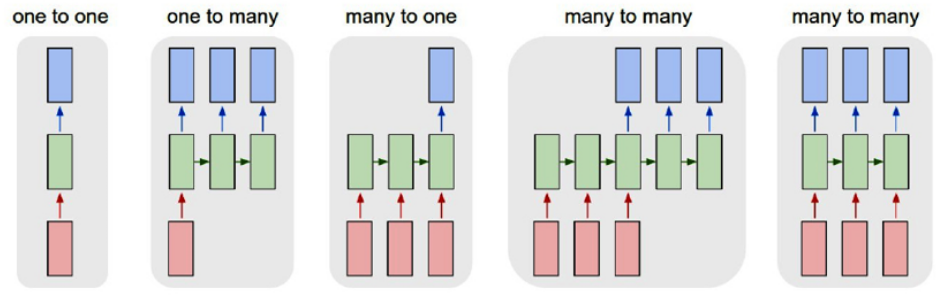

Of these, the first one one-to-one) is not interesting from a sequence processing point of view, since it can be implemented as a simple Dense network with one input and one output.  
  
The one-to-many case has a single input and outputs a sequence. An example of such a network might be a network that can generate text tags from images [6], containing short text descriptions of different aspects of the images. Such a network would be trained with image input and labled sequences of text representing the image tags.  
  
The many-to-one case is the reverse; it takes a sequence of tensors as input but outputs a single tensor. Examples of such networks would be a sentiment analysis network [7], which takes as input a block of text such as a movie review and outputs a single sentiment value.  
  
The many-to-many use case comes in two flavors. The first one is more popular and is better known as the seq2seq model. In this model, a sequence is read in and produces a context vector representing the input sequence, which is used to generate the output sequence.  
  
The topology has been used with great success in the field of machine translation, as well as problems that can be reframed as machine translation problems. Real life examples of the former can be found in [8,9], and an example of the latter is described in [10].  
  
The second many-to-many type has an output cell corresponding to each input cell. This kind of network is suited for use case where there is a 1:1 correspondence between the input and output, such as time series. The major difference between this model and the seq2seq model is that the input does not have to be completely encoded before the decoding process begins.  
  
In the next three sections, we provide examples of a one-to-many network that learns to generate text, a many-to-one network that does sentiment analysis, and a many-to-many network of the second type, which predicts **Part-of-speech (POS)** for words in a sentence.

## Example - One-to-Many - learning to generate text

RNNs have been used extensively by the **Natural Language Processing (NLP)** community for various applications. One such application is to build language models. A language model is a model that allow us to predict the probability of a word in a text given previous words. Language models are important for various higher-level tasks such as machine translation, spelling correction, and so on.  
  
The ability of a language model to predict the next word in a sequence makes it a generative model that allows us to generate text by sampling from the output probabilities of different words in the vocabulary. The training data is a sequence of words, and the label is the word appearing at the next time step in the sequence.  
  
For our example, we will train a character-based RNN on the text of the children's stories "Alice in Wonderland" and its sequel "Through the Looking Glass" by Lewis Carroll. We have chosen to build a character-based model because it has a smaller vocabulary and trains quicker. The idea is the same as training and using a word-based language model, except we will use characters instead of words. Once trained, the model can be used to generate some text in the same style.  
  
The data for our example will come from the plain texts of two novels from the Project Gutenberg website [36]. Input to the network are sequence of 100 characters, and the corresponding output is another sequence of 100 characters, offset from the input by 1 position.  
  
That is, if the input is the sequence [$c_1,\, c_2,\, ...,\,c_n$], the output will be [$c_2,\, c_3,\, ...,\, c_{n+1}$]. We will train the network for 50 epochs, and at the end of every 10 epochs, we will generate a fixed size sequence of characters starting with a standard prefix. In the following example, we have used the prefic "Alice", the name of the protagonist in our novels.

In [1]:
import os
import numpy as np
import re
import shutil
import tensorflow as tf

In [2]:
DATA_DIR = "data" # where you download the source code
CHECKPOINT_DIR = os.path.join(DATA_DIR, "checkpoints") # where we will save the weights

In [3]:
# download text data and preprocessing
def download_and_read(urls):
    texts = []
    for i, url in enumerate(urls):
        # check to see whether the file is already downloaded, and if not download a file
        p = tf.keras.utils.get_file('ex1-{:d}.txt'.format(i), url, cache_dir=".")
        text = open(p, 'r', encoding='utf8').read()
        
        # remove byte order mark
        text = text.replace('\ufeff', '')
        
        # remove newlines
        text = text.replace('\n', ' ')
        text = re.sub(r'\s+', ' ', text)
        
        # add it to the list
        texts.extend(text)
    return texts

In [4]:
# download and read into local data structure (list of chars)
texts = download_and_read([
    "http://www.gutenberg.org/cache/epub/28885/pg28885.txt",
    "https://www.gutenberg.org/files/12/12-0.txt"
])

In [5]:
print(type(texts))
print(len(texts))
print(texts[1:10])

<class 'list'>
345739
['r', 'o', 'j', 'e', 'c', 't', ' ', 'G', 'u']


Next, we will create our vocaburary. In our case, our vocabulary contains 90 uinque characters, composed of uppercase and lowercase alphabets, numbers, and special characters. We also create some mapping dictionaries to convert each vocabulary character to a unique integer and vice versa. As noted earlier, the input and output of the network is a sequence of characters. However, the actual input and output of the network are sequences of integers, and we will use these mapping dictionaries to handle this conversion.

In [6]:
# create the vocabulary
vocab = sorted(set(texts))
print('vocab size: {:d}'.format(len(vocab)))

# create mapping from vocab chars to ints
char2idx = {c:i  for i, c in enumerate(vocab)}
idx2char = {i:c for c, i in char2idx.items()}

vocab size: 90


The next step is to use these mapping dictionaries to convert our character sequence input into an integer sequence, and then into a TensorFlow dataset. Each of our sequences is going to be 100 characters long, with the output being offset from the input by 1 character position. We first batch the dataset into slices of 101 characters, then apply the **`split_train_labels()`** function to every element of the dataset to create our sequences dataset, which is a dataset of tuples of two elements, each element of the tuple being a vector of size 100 and type **`tf.int64`**. We then shuffle these sequences and then create batches of 64 tuples each for input to our network. Each element of the dataset is now a tuple consisting of a pair of matrices, each of size (64, 100) and type **`tf.int64`**

In [7]:
# numericize the texts
texts_as_ints = np.array([char2idx[c] for c in texts])
data = tf.data.Dataset.from_tensor_slices(texts_as_ints)
print(type(data))

<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>


In [8]:
i=0
for element in data:
    print(element)
    i=i+1
    if i==10: break

tf.Tensor(44, shape=(), dtype=int32)
tf.Tensor(75, shape=(), dtype=int32)
tf.Tensor(72, shape=(), dtype=int32)
tf.Tensor(67, shape=(), dtype=int32)
tf.Tensor(62, shape=(), dtype=int32)
tf.Tensor(60, shape=(), dtype=int32)
tf.Tensor(77, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(35, shape=(), dtype=int32)
tf.Tensor(78, shape=(), dtype=int32)


In [9]:
# number of characters to show before asking for prediction
# sequence : [None, 100]
seq_length = 100
sequences = data.batch(seq_length + 1, drop_remainder=True)

In [10]:
print(type(sequences))
print(sequences)
print(list(sequences.as_numpy_iterator())[0])

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
<BatchDataset shapes: (101,), types: tf.int32>
[44 75 72 67 62 60 77  0 35 78 77 62 71 59 62 75 64  7 76  0 29 69 66 60
 62  7 76  0 29 61 79 62 71 77 78 75 62 76  0 66 71  0 51 72 71 61 62 75
 69 58 71 61 11  0 59 82  0 40 62 80 66 76  0 31 58 75 75 72 69 69  0 48
 65 66 76  0 62 30 72 72 68  0 66 76  0 63 72 75  0 77 65 62  0 78 76 62
  0 72 63  0 58]


In [11]:
# batch function example 1
example_dataset = tf.data.Dataset.range(8)
example_dataset = example_dataset.batch(3)
print(list(example_dataset.as_numpy_iterator()))
# batch function example 2
example_dataset = tf.data.Dataset.range(8)
example_dataset = example_dataset.batch(3, drop_remainder=True)
list(example_dataset.as_numpy_iterator())

[array([0, 1, 2], dtype=int64), array([3, 4, 5], dtype=int64), array([6, 7], dtype=int64)]


[array([0, 1, 2], dtype=int64), array([3, 4, 5], dtype=int64)]

In [12]:
def split_train_labels(sequence):
    input_seq = sequence[0:-1]
    output_seq = sequence[1:]
    return input_seq, output_seq

sequences = sequences.map(split_train_labels)

In [13]:
i=0
for element in sequences:
    print(element)
    i=i+1
    if i==1: break

(<tf.Tensor: shape=(100,), dtype=int32, numpy=
array([44, 75, 72, 67, 62, 60, 77,  0, 35, 78, 77, 62, 71, 59, 62, 75, 64,
        7, 76,  0, 29, 69, 66, 60, 62,  7, 76,  0, 29, 61, 79, 62, 71, 77,
       78, 75, 62, 76,  0, 66, 71,  0, 51, 72, 71, 61, 62, 75, 69, 58, 71,
       61, 11,  0, 59, 82,  0, 40, 62, 80, 66, 76,  0, 31, 58, 75, 75, 72,
       69, 69,  0, 48, 65, 66, 76,  0, 62, 30, 72, 72, 68,  0, 66, 76,  0,
       63, 72, 75,  0, 77, 65, 62,  0, 78, 76, 62,  0, 72, 63,  0])>, <tf.Tensor: shape=(100,), dtype=int32, numpy=
array([75, 72, 67, 62, 60, 77,  0, 35, 78, 77, 62, 71, 59, 62, 75, 64,  7,
       76,  0, 29, 69, 66, 60, 62,  7, 76,  0, 29, 61, 79, 62, 71, 77, 78,
       75, 62, 76,  0, 66, 71,  0, 51, 72, 71, 61, 62, 75, 69, 58, 71, 61,
       11,  0, 59, 82,  0, 40, 62, 80, 66, 76,  0, 31, 58, 75, 75, 72, 69,
       69,  0, 48, 65, 66, 76,  0, 62, 30, 72, 72, 68,  0, 66, 76,  0, 63,
       72, 75,  0, 77, 65, 62,  0, 78, 76, 62,  0, 72, 63,  0, 58])>)


In [14]:
print(len(texts))
i=0
for element in sequences:
    i=i+1
print(i)
print(len(texts)/101)

345739
3423
3423.158415841584


In [15]:
# set up for training
# batches : [None, 64, 100]
batch_size = 64
steps_per_epoch = len(texts) // seq_length // batch_size
print(steps_per_epoch)
print(sequences)
dataset = sequences.shuffle(10000).batch(batch_size, drop_remainder=True)
print(dataset)

54
<MapDataset shapes: ((100,), (100,)), types: (tf.int32, tf.int32)>
<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int32, tf.int32)>


In [22]:
i=0
for element in dataset:
    print(element)
    i=i+1
    if i==1: break

(<tf.Tensor: shape=(64, 100), dtype=int32, numpy=
array([[60, 72, 58, ..., 63, 77, 62],
       [58,  0, 69, ..., 59, 69, 62],
       [65, 62, 82, ...,  0, 71, 72],
       ...,
       [66, 71, 61, ...,  0, 65, 62],
       [45, 78, 62, ...,  0, 63, 58],
       [78, 77, 62, ...,  0, 16, 13]])>, <tf.Tensor: shape=(64, 100), dtype=int32, numpy=
array([[72, 58, 77, ..., 77, 62, 75],
       [ 0, 69, 66, ..., 69, 62, 13],
       [62, 82,  7, ..., 71, 72,  0],
       ...,
       [71, 61,  0, ..., 65, 62, 75],
       [78, 62, 62, ..., 63, 58, 71],
       [77, 62, 71, ..., 16, 13,  0]])>)


We are now ready to define our network. As before, we define our network as a subclass of **`tf.keras.Model`** as shown next. The network is fairly simple; it takes as input a sequence of integers of size 100 (**`num_timesteps`**) and passes them through an Embedding layer so that each integer in the sequence is converted to a vector of size 256 (**`embedding_dim`**). So, assuming a batch size of 64, for our input sequence of size (64, 100), the output of the Embedding layer is a matrix of shape (64, 100, 256).  
  
The next layer is the RNN layer with 100 time steps. The implementation of RNN chosen is a GRU. This GRU layer will take, at each of its time steps, a vector of size (256,) and output a vector of shape (1024,) (**`rnn_output_dim`**). Note also that the RNN is stateful, which means that the hidden state output from the previous training epoch will be used as input to the current epoch. The **`return_sequences=True`** flag also indicates that the RNN will output at each of the time steps rather than an aggregate output at the last time steps.  
  
Finally, each of the time steps will emit a vector of shape (1024,) into a Dense layer that outputs a vector of shape (90,)(**`vocab_size`**). The output from this layer will be a tensor of shape (64, 100, 90). Each position in the output vector corresponds to a character in our vocabulary, and the values correspond to the probability of that character occurring at that output position.

In [16]:
class CharGenModel(tf.keras.Model):
    def __init__(self, vocab_size, num_timesteps, embedding_dim, **kwargs):
        super(CharGenModel, self).__init__(**kwargs)
        self.embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.rnn_layer = tf.keras.layers.GRU(num_timesteps,
                                            recurrent_initializer='glorot_uniform',
                                            recurrent_activation='sigmoid',
                                            stateful=True,
                                            return_sequences=True)
        self.dense_layer = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        x = self.embedding_layer(x)
        x = self.rnn_layer(x)
        x = self.dense_layer(x)
        return x

In [17]:
vocab_size = len(vocab)
embedding_dim = 256

In [18]:
model = CharGenModel(vocab_size, seq_length, embedding_dim)
model.build(input_shape=(batch_size, seq_length))

In [19]:
model.summary()

Model: "char_gen_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  23040     
_________________________________________________________________
gru (GRU)                    multiple                  107400    
_________________________________________________________________
dense (Dense)                multiple                  9090      
Total params: 139,530
Trainable params: 139,530
Non-trainable params: 0
_________________________________________________________________


Next we define a loss function and compile our model. We will use the sparse categorical cross-entropy as our loss function because that is the standard loss function to use when our inputs and outputs are sequences of integers. For the optimizer, we will choose the Adam optimizer:

In [20]:
def loss(labels, predictions):
    return tf.losses.sparse_categorical_crossentropy(labels, predictions, from_logits=True)

In [21]:
model.compile(optimizer=tf.optimizers.Adam(), loss=loss)

Normally, the character at each position of the output is found by computing the argmax of the vector at that position, that is, the character corresponding to the maximum probability value. This is known as greedy search. In the case of language models where the output of one timestep becomes the input to the next timestep, this can lead to repetitive output. The two most common approaches to overcome this problem is either to sample the output randomly or to use beam search, which samples from $k$ the most probable values at each time step. Here we will use the **`tf.random.categorical()`** function to sample the output randomly. The following function takes a string as a prefix and uses it to generate a string whose length is specified by **`num_chars_to_generate`**. The temperature parameter is used to control the quality of the predictions. Lower values will create a more predictable output.  
  
The logic follows a predictable pattern. We convert the sequence of characters in our **`prefix_string`** into a sequence of integers, then **`expand_dims`** to add a batch dimension so the input can be passed into our model. We then reset the state of the model. This is needed because our model is stateful, and we don't want the hidden state for the first timestep in our prediction run to be carried over from the one computed during training. We then run the input through our model and get back a prediction. This is the vector of shape (90,) representing the probabilities of each character in the vocabulary appearing at the next time step. We then reshape the prediction by removing the batch dimension and dividing by the temperature, then randomly sample from the vector. We then set our prediction as the input to the next time step. We repeat this for the number of characters we need to generate, converting each prediction back to character form and accumulating in a list, and returning the list at the end of the loop:

In [72]:
def generate_text(model, prefix_string, char2idx, idx2char, 
                 num_chars_to_generate=1000, temperature=1.0):
    input = [char2idx[s] for s in prefix_string]
    input = tf.expand_dims(input, 0)
    print(input)
    
    text_generated = []
    model.reset_states()
    
    for i in range(num_chars_to_generate):
        preds = model(input)
        # 차원이 1인 차원을 모두 제거한다
        preds = tf.squeeze(preds, 0) / temperature
        # predict char returned by model
        pred_id = tf.random.categorical(preds, num_samples=1)[-1, 0].numpy()
        text_generated.append(idx2char[pred_id])
        # pass the prediction as the next input to the model
        input = tf.expand_dims([pred_id], 0)
        
    return prefix_string + "".join(text_generated)

In [73]:
# tf.random.categorical example
outs = np.array([[0.1,0.2,0.3,0.4,0.5,0], [0.1,0.2,0.3,0.4,0.5,0]])
tf.random.categorical(outs, num_samples=1).numpy()

array([[4],
       [2]], dtype=int64)

Finally, we are ready to run our training and evaluation loop. As mentioned earlier, we will train our network for 50 epochs, and at every 10 epoch intervals, we will try to generate some text with the model trained so far. Our prefix at each stage is the string "Alice". Notice that in order to accommodate a single string prefix, we save the weights after every 10 epochs and build a separate generative model with these weights but with an input shape with a batch size of 1. Here is the code to do this:

In [74]:
num_epochs = 50
for i in range(num_epochs // 10):
    # When passing an infinitely repeating dataset, you must specify the steps_per_epoch argument
    # steps_per_epoch = len(texts) // seq_length // batch_size = 345739 // 100 // 64 = 54
    model.fit(dataset.repeat(), epochs=10, steps_per_epoch=steps_per_epoch)
    
    checkpoint_file = os.path.join(CHECKPOINT_DIR, 'model_epoch_{:d}'.format(i+1))
    model.save_weights(checkpoint_file)
    
    # create generative model using the trained model so far
    gen_model = CharGenModel(vocab_size, seq_length, embedding_dim)
    gen_model.load_weights(checkpoint_file)
    gen_model.build(input_shape=(1, seq_length))
    print('after epoch: {:d}'.format(i+1))
    print(generate_text(gen_model, "Alice ", char2idx, idx2char))
    print("---")

Train for 54 steps
Epoch 1/10
54/54 [==============================] - 2s 44ms/step - loss: 3.5072
Epoch 2/10
54/54 [==============================] - 1s 14ms/step - loss: 2.7574
Epoch 3/10
54/54 [==============================] - 1s 13ms/step - loss: 2.4664
Epoch 4/10
54/54 [==============================] - 1s 14ms/step - loss: 2.3243
Epoch 5/10
54/54 [==============================] - 1s 13ms/step - loss: 2.2221
Epoch 6/10
54/54 [==============================] - 1s 13ms/step - loss: 2.1304
Epoch 7/10
54/54 [==============================] - 1s 15ms/step - loss: 2.0514
Epoch 8/10
54/54 [==============================] - 1s 13ms/step - loss: 1.9877
Epoch 9/10
54/54 [==============================] - 1s 14ms/step - loss: 1.9303
Epoch 10/10
54/54 [==============================] - 1s 14ms/step - loss: 1.8801
after epoch: 1
tf.Tensor([[29 69 66 60 62  0]], shape=(1, 6), dtype=int32)
Alice quiyst font of could groulrwive Knight tamty _ingle to side to word, she wave on, lonk arffor the n

after epoch: 3
tf.Tensor([[29 69 66 60 62  0]], shape=(1, 6), dtype=int32)
Alice at agreemenn--and are unofursed: "-ive chated the pand," said the KD be.u--he quite heres-thing was exaid it’s away whith not. ‘Ah in eyes under you through again. ‘Howeveret was Alice exprashed with a funting: and thek is good, ‘whow I'm any house becound prabble. ‘It hep what you daying likes on the lade or heads fard of the knowide’ noi's the spried, ‘It’s the ough she dillit little fround to one she said to preeds and dozmen lat speaving at a G bot some, ‘I donout out it's Alice exalked), oper dyou very brown butidn the ganders are?’ he would to her tevergahe up one minking up box Shewere of the gamem!’ However fave,’ the Grace trild here pertaly one, sI poor Doon’t behection DoUn would up if they cake from some said--omnith as he said, as! And maks his for up do is Alice’s cause three never rate--sellon. ‘You arge prominse; how a pust herself. of me_ time as we real regust cage!” This is party to be t

after epoch: 5
tf.Tensor([[29 69 66 60 62  0]], shape=(1, 6), dtype=int32)
Alice in the if shouting like they moment, whengeding, (she meal only tell this wild of jost bulary went on in sumption--You could any had spoke. ‘I she she though Ho--much whaturedual acribling that moment she was growlest thortezes asking feening took the pair of the good change a lit hawning abont with his head, this fast quiter southoughe that she went oniods arpeed not you thinking require I don't much THE ‘To BINHAS LIME date Time where looking to me, and me that than” the meantly. ‘Doow 60y as, "yet wonder head memere or way thought to have Zeall, and holding a long afremulave up like unshed intouquired hashap is now in a remise won't el, the moment. That I shaddly with befory Tell mang at braint, sure as he think, as she never had SUC orment it make you tele you at the round the ragering Twe work is moment copyr, donghis asked. ‘Hest have dobling said in the head.’ Then the juring looking, ever feedristr

In [25]:
#i=4
#checkpoint_file = os.path.join(CHECKPOINT_DIR, 'model_epoch_{:d}'.format(i+1))
# create generative model using the trained model so far
gen_model = CharGenModel(vocab_size, seq_length, embedding_dim)
gen_model.load_weights(checkpoint_file)
gen_model.build(input_shape=(1, seq_length))

prefix_string = "Alice "
num_chars_to_generate=1000
temperature=1.0
input = [char2idx[s] for s in prefix_string]
input = tf.expand_dims(input, 0)
print("input = ", input)

text_generated = []
gen_model.reset_states()

input =  tf.Tensor([[29 69 66 60 62  0]], shape=(1, 6), dtype=int32)


In [37]:
print("input = ", input)
preds = gen_model(input)
#print("preds = ", preds)
print("shape of preds = ", tf.shape(preds))
# 차원이 1인 차원을 모두 제거한다
preds = tf.squeeze(preds, 0) / temperature
#print("preds = ", preds)
print("shape of preds = ", tf.shape(preds))
# predict char returned by model
pred_id = tf.random.categorical(preds, num_samples=1)[-1, 0].numpy()
print("pred_id = ", pred_id)
text_generated.append(idx2char[pred_id])
# pass the prediction as the next input to the model
input = tf.expand_dims([pred_id], 0)
print("input = ", input)
print(prefix_string + "".join(text_generated))

input =  tf.Tensor([[13]], shape=(1, 1), dtype=int32)
shape of preds =  tf.Tensor([ 1  1 90], shape=(3,), dtype=int32)
shape of preds =  tf.Tensor([ 1 90], shape=(2,), dtype=int32)
pred_id =  0
input =  tf.Tensor([[0]], shape=(1, 1), dtype=int32)
Alice Queen said. 


Generating the next character or next word in the text isn't the only thing you can do with this sort of model. Similar models have been built to make stock price predictions [3] or generate classical music [4]. Andrej Karpathy covers a few other fun examples, such as generating fake Wikipedia pages, algebraic geometry proofs, and Linux source code in his blog post [5].

##### Finding Recurrent Weights in Keras Models
http://dieuwkehupkes.nl/finding-recurrent-network-weights-in-keras-models/

In [96]:
model.summary()

Model: "char_gen_model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     multiple                  23040     
_________________________________________________________________
gru_15 (GRU)                 multiple                  107400    
_________________________________________________________________
dense_15 (Dense)             multiple                  9090      
Total params: 139,530
Trainable params: 139,530
Non-trainable params: 0
_________________________________________________________________


In [95]:
print(90*256)
print(256*300 + 100*300 + 2*300)
print(100*90 + 90)

23040
107400
9090


In [98]:
layer = model.layers
print(type(layer))
print(len(layer))    

<class 'list'>
3


In [82]:
print(type(layer[0]))
print(np.array(layer[0].get_weights()).shape)
print(layer[0].get_weights()) # Embedding weight (vocab_size, embedding_dim)

<class 'tensorflow.python.keras.layers.embeddings.Embedding'>
(1, 90, 256)
[array([[ 0.26778358,  0.14073066,  0.05675163, ...,  0.09043368,
        -0.06599912, -0.02633516],
       [ 0.05916423,  0.0448539 ,  0.02654708, ...,  0.12572585,
         0.16853797, -0.3106895 ],
       [-0.42652538, -0.2564568 , -0.15568848, ...,  0.19001462,
        -0.20032667,  0.05001416],
       ...,
       [-0.04328665,  0.39928776, -0.08013626, ...,  0.07190275,
        -0.03168827, -0.01062302],
       [ 0.1263382 , -0.27828345,  0.00926217, ..., -0.00810243,
        -0.15744488, -0.15960252],
       [-0.41662925,  0.02112138, -0.15780659, ..., -0.2388641 ,
        -0.15465741, -0.09985715]], dtype=float32)]


In [88]:
# GRU.get_weights() = [[W_z; W_r; W_h], [U_z; U_r; U_h], [bias_z; bias_r; bias_h]]
print(layer[1])
print(np.array(layer[1].get_weights()).shape)
print(np.array(layer[1].get_weights()[0]).shape)
print(layer[1].get_weights()[0])
print(np.array(layer[1].get_weights()[1]).shape)
print(layer[1].get_weights()[1])
print(np.array(layer[1].get_weights()[2]).shape)
print(layer[1].get_weights()[2])

(3,)
(256, 300)
[[ 0.24795751  0.07343243  0.21317954 ... -0.13620438  0.0474769
   0.13917877]
 [ 0.08750629 -0.38772243  0.21731336 ... -0.00584234  0.21822192
   0.00882357]
 [ 0.20219883  0.03689376  0.23654753 ...  0.09130376  0.19799012
   0.1653673 ]
 ...
 [ 0.20512366  0.06985644 -0.02599016 ... -0.23582797  0.06455479
   0.15002544]
 [-0.05482098 -0.82890046 -0.14881723 ...  0.1088066  -0.02259773
  -0.32905933]
 [ 0.0953943  -0.29443857 -0.3205966  ... -0.13623752 -0.10802563
  -0.15526198]]
(100, 300)
[[ 0.59475607  0.00395553  0.11743008 ...  0.21306913 -0.10098467
   0.25023615]
 [ 0.2523791   0.150349   -0.20757194 ... -0.18094347  0.24435619
  -0.05201368]
 [ 0.3856921  -0.5289771   0.30385676 ...  0.07808218  0.1032107
  -0.13689665]
 ...
 [ 0.14289099 -0.07177863  0.25060338 ...  0.1258786  -0.24700046
  -0.28541288]
 [ 0.13134225  0.02714729  0.15838619 ...  0.22576825 -0.38151023
   0.165376  ]
 [ 0.15946248  0.4752455  -0.12602676 ... -0.10984415  0.30885765
  -0.50

In [94]:
print(layer[2])
print(np.array(layer[2].get_weights()).shape)
print(np.array(layer[2].get_weights()[0]).shape)
print(layer[2].get_weights()[0]) # Dense layer weight (hidden_size, vocab_size)
print(np.array(layer[2].get_weights()[1]).shape)
print(layer[2].get_weights()[1]) # Dense layer bias (vocab_size)

(2,)
(100, 90)
[[-6.1648123e-02  1.4566829e-02 -8.8878334e-02 ... -1.4197947e-01
   3.3081061e-01  4.5100499e-02]
 [-1.5698774e-01  1.4725000e-01  4.0291224e-02 ...  1.5349483e-01
  -9.9739909e-02  7.2362244e-02]
 [-1.9380079e-01  9.6069440e-02 -2.2522257e-01 ...  2.1722134e-02
   6.8317443e-02  1.9842726e-01]
 ...
 [-2.7515319e-01  7.3970757e-02  5.8239054e-02 ...  4.8798716e-01
   3.0877373e-01  2.4814221e-01]
 [-4.0878326e-04 -1.5241326e-01  3.2432508e-01 ... -3.3062413e-01
   1.9408335e-01  4.1716906e-01]
 [-4.7718447e-01 -3.6467710e-01 -2.2420247e-01 ... -1.4252359e-01
   6.5492883e-02 -3.5348728e-01]]
(90,)
[ 0.05119661 -0.08228639  0.00048663 -0.06652822 -0.0930901  -0.07534965
 -0.09235021  0.04878366 -0.04558447 -0.03672883 -0.04797948  0.07834122
  0.00903162  0.06899058 -0.06877542 -0.07986989 -0.06385493 -0.04087685
 -0.04949396 -0.05041421 -0.04822309 -0.04784084 -0.05818423 -0.05625573
 -0.04168389 -0.12286945 -0.12159686 -0.116497   -0.07806297 -0.00200496
 -0.05199669 -

##### get layer outputs

In [41]:
model.summary()

Model: "char_gen_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      multiple                  23040     
_________________________________________________________________
gru_2 (GRU)                  multiple                  107400    
_________________________________________________________________
dense_2 (Dense)              multiple                  9090      
Total params: 139,530
Trainable params: 139,530
Non-trainable params: 0
_________________________________________________________________


In [44]:
layer_output = model.get_layer('gru_2')
#intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output)
#intermediate_prediction=intermediate_model.predict(x_train[2].reshape(1,28,28,1))
  

In [45]:
print(layer_output)

In [ ]:
#from keras import backend as K

inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [tf.keras.backend.function([inp, K.learning_phase()], [out]) for out in outputs]    # evaluation functions

# Testing
#test = np.random.random(input_shape)[np.newaxis,...]
#layer_outs = [func([test, 1.]) for func in functors]
#print layer_outs

## Example - Many-to-One - Sentiment Analysis

In this example, we will use a many-to-one network that takes a sentence as input and predicts its sentiment as being either positive or negative. Our dataset is the Sentiment labeled sentences dataset on the UCI Machine Learning Repository [20], a set of 3,000 sentences from reviews on Amazon, IMDb, and Yelp, each labeled with 0 if it expresses a negative sentiment, or 1 if it expresses a positive sentiment.

In [1]:
import numpy as np
import os
import shutil
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix

The dataset is provided as a zip file, which expands into a folder containing three files of labeled sentences, one for each provider, with one sentence and label per line, with the sentence and label separated by the tab character. We first download the zip file, then parse the files into a list of (sentence, label) pairs:

In [2]:
def download_and_read(url):
    local_file = url.split('/')[-1]
    local_file = local_file.replace("%20", " ")
    p = tf.keras.utils.get_file(local_file, url, extract=True, cache_dir=".")
    local_folder = os.path.join("datasets", local_file.split('.')[0])
    
    labeled_sentences = []
    for labeled_filename in os.listdir(local_folder):
        if labeled_filename.endswith("_labelled.txt"):
            with open(os.path.join(local_folder, labeled_filename), "r") as f:
                for line in f:
                    sentence, label = line.strip().split('\t')
                    labeled_sentences.append((sentence, label))
    return labeled_sentences

In [3]:
# download and read data into data structures
labeled_sentences = download_and_read("https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip")

In [4]:
sentences = [s for (s, l) in labeled_sentences]
labels = [int(l) for (s, l) in labeled_sentences]

In [5]:
print(type(sentences), len(sentences))

<class 'list'> 3000


In [6]:
print(type(labels), len(labels))

<class 'list'> 3000


In [7]:
sentences[0]

'So there is no way for me to plug it in here in the US unless I go by a converter.'

In [8]:
labels[0]

0

Our objective is to train the model so that, given a sentence as input, it learns to predict the corresponding sentiment provided in the label. Each sentence is a sequence of words. However, in order to input it into the model, we have to convert it into a sequence of integers. Each integer in the sequence will point to a word. The mapping of integers to words for our corpus is called a vocabulary. Thus we need to tokenize the sentences and produce a vocabulary. This is done using the following code:

In [21]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(sentences)
vocab_size = len(tokenizer.word_counts)
print('vocabulary size: {:d}'.format(vocab_size))
word2idx = tokenizer.word_index
idx2word = {v:k for (k, v) in word2idx.items()}

vocabulary size: 5271


Our vocabulary consists of 5271 unique words. It is possible to make the size smaller by dropping words that occur fewer than some threshold number of times, which can be found by inspecting the **`tokenizer.word_counts`** dictionary. In such cases, we need to add 1 to the vocabulary size for the UNK (unknown) entry, which will be used to replace every word that is not found in the vocabulary.  
  
We also construct lookup dictionaries to convert from word to word index and back. The first dictionary is useful during training, in order to construct integer sequences to feed the network. The second dictionary is used to convert from word index back to word in our prediction code later.  
  
Each sentence can have a different number of words. Our model will require us to provide sequences of integers of identical length for each sentence. In order to support this requirement, it is common to choose a maximum sequence length that is large enough to accommodate most of the sentences in the training set. Any sentences that are shorter will be padded with zeros, and any sentences that are longer will be trauncated. An easy way to choose a good value for the maximum sequence length is to look at the sentence length (in number of words) at different percentile positions:

In [23]:
seq_lengths = np.array([len(s.split()) for s in sentences])
print([(p, np.percentile(seq_lengths, p)) for p in [75,80,90,95,99,100]])

[(75, 16.0), (80, 18.0), (90, 22.0), (95, 26.0), (99, 36.0), (100, 71.0)]


As can be seen, the maximum sentence length is 71 words, but 99% of the sentences are under 36 words. If we choose a value of 64, for example, we should be able to get away with not having to truncate most of the sentences.  
  
The preceding blocks of code can be run interactively multiple times to choose good values of vocabulary size and maximum sequence length respectively. In our example, we have chosen to keep all the words (so **`vocab_size = 5271`**), and we have set our **`max_seqlen`** to 64.  
  
Our next step is to create a dataset that our model can consume. We first use our trained tokenizer to convert each sentence from a sequence of words (**`sentences`**) to a sequence of integers (**`sentences_as_ints`**), where each corresponding integer is the index of the word in the **`tokenizer.word_index`**. It is then truncated and padded with zeros. The labels are also converted to a NumPy array **`labels_as_ints`**, and finally, we combine the tensors **`sentences_as_ints`** and **`labels_as_ints`** to form a TensorFlow dataset:

In [25]:
max_seqlen = 64
# create dataset
sentences_as_ints = tokenizer.texts_to_sequences(sentences)
sentences_as_ints = tf.keras.preprocessing.sequence.pad_sequences(sentences_as_ints, maxlen=max_seqlen)
labels_as_ints = np.array(labels)
dataset = tf.data.Dataset.from_tensor_slices((sentences_as_ints, labels_as_ints))

We want to set aside 1/3 of the dataset for evaluation. Of the remaining data, we will use 10% as an inline validation dataset that the model will use to gauge its own progress during training, and the remaining as the training dataset. Finally, we create batches of 64 sentences for each dataset:

In [26]:
dataset = dataset.shuffle(10000)
test_size = len(sentences) // 3 # = 1000
val_size = (len(sentences) - test_size) // 10 # = 200

In [31]:
test_dataset = dataset.take(test_size)
val_dataset = dataset.skip(test_size).take(val_size)
train_dataset = dataset.skip(test_size + val_size)
batch_size = 64
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

Next we define our model. As you can see, the model is fairly straightforward, each input sentence is a sequence of integers of size **`max_seqlen`** (64). This is input into an Embedding layer that converts each word into a vector given by the size of the vocabulary + 1. The additional word is to account for the padding integer 0 that was introduced during the **`pad_sequences()`** call above. The vector at each of the 64 time steps are then fed into a bidirectional LSTM layer, which converts each word to a vector of size (64,). The output of the LSTM at each time step is fed into a Dense layer, which produces a vector of size (64,) with ReLU activation. The output of this Dense layer is then fed into another Dense layer, which outputs a vector of (1,) at each time step, modulated through a sigmoid activation.  
The model is compiled with the binary corss-entropy loss function and the Adam optimizer, and then trained over 10 epochs:

In [34]:
class SentimentAnalysisModel(tf.keras.Model):
    def __init__(self, vocab_size, max_seqlen, **kwargs):
        super(SentimentAnalysisModel, self).__init__(**kwargs)
        self.embedding = tf.keras.layers.Embedding(vocab_size, max_seqlen)
        self.bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(max_seqlen))
        self.dense = tf.keras.layers.Dense(64, activation='relu')
        self.out = tf.keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.embedding(x)
        x = self.bilstm(x)
        x = self.dense(x)
        x = self.out(x)
        return x

In [35]:
model = SentimentAnalysisModel(vocab_size+1, max_seqlen)
model.build(input_shape=(batch_size, max_seqlen))
model.summary()

Model: "sentiment_analysis_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  337408    
_________________________________________________________________
bidirectional (Bidirectional multiple                  66048     
_________________________________________________________________
dense (Dense)                multiple                  8256      
_________________________________________________________________
dense_1 (Dense)              multiple                  65        
Total params: 411,777
Trainable params: 411,777
Non-trainable params: 0
_________________________________________________________________


In [36]:
# compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
# train
data_dir = '.\\data'
logs_dir = os.path.join('.\\logs')
best_model_file = os.path.join(data_dir, "best_model.h5")

checkpoint = tf.keras.callbacks.ModelCheckpoint(best_model_file, 
                    save_weights_only=True, save_best_only=True)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

In [44]:
num_epochs = 10
history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset,
                   callbacks=[checkpoint, tensorboard])

Train for 29 steps, validate for 4 steps
Epoch 1/10
29/29 [==============================] - 6s 192ms/step - loss: 0.6917 - accuracy: 0.5300 - val_loss: 0.6798 - val_accuracy: 0.5950
Epoch 2/10
29/29 [==============================] - 1s 18ms/step - loss: 0.6322 - accuracy: 0.7144 - val_loss: 0.5039 - val_accuracy: 0.8150
Epoch 3/10
29/29 [==============================] - 1s 18ms/step - loss: 0.4261 - accuracy: 0.8400 - val_loss: 0.3074 - val_accuracy: 0.9150
Epoch 4/10
29/29 [==============================] - 1s 17ms/step - loss: 0.2562 - accuracy: 0.9011 - val_loss: 0.1648 - val_accuracy: 0.9350
Epoch 5/10
29/29 [==============================] - 1s 18ms/step - loss: 0.1598 - accuracy: 0.9467 - val_loss: 0.0733 - val_accuracy: 0.9650
Epoch 6/10
29/29 [==============================] - 1s 18ms/step - loss: 0.1053 - accuracy: 0.9644 - val_loss: 0.0728 - val_accuracy: 0.9850
Epoch 7/10
29/29 [==============================] - 1s 17ms/step - loss: 0.0738 - accuracy: 0.9744 - val_loss: 0

In [ ]:
%load_ext tensorboard

In [50]:
%tensorboard --logdir ./logs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 3452.

Our checkpoint callback has saved the best model based on the lowest value of validation loss, and we can now reload this for evaluation against our held out test set:

In [51]:
best_model = SentimentAnalysisModel(vocab_size+1, max_seqlen)
best_model.build(input_shape=(batch_size, max_seqlen))
best_model.load_weights(best_model_file)
best_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
test_loss, test_acc = best_model.evaluate(test_dataset)
print('test loss: {:.3f}, test accuracy: {:.3f}'.format(test_loss, test_acc))

16/16 [==============================] - 1s 42ms/step - loss: 0.0472 - accuracy: 0.9910
test loss: 0.047, test accuracy: 0.991


we can also use **`model.predict()`** to retrieve our predictions and compare them individually to the labels and use external tools (from scikit-learn, for example) to compute our results:

In [54]:
labels, predictions = [], []
idx2word[0] = 'PAD'
is_first_batch = True
for test_batch in test_dataset:
    inputs_b, labels_b = test_batch
    pred_batch = best_model.predict(inputs_b)
    predictions.extend([(1 if p>0.5 else 0) for p in pred_batch])
    labels.extend([i for i in labels_b])
    
    if is_first_batch:
        # print first batch of label, prediction, and sentence
        for rid in range(inputs_b.shape[0]):
            words = [idx2word[idx] for idx in inputs_b[rid].numpy()]
            words = [w for w in words if w != "PAD"]
            sentence = " ".join(words)
            print('{:d}\t{:d}\t{:s}'.format(labels[rid], predictions[rid], sentence))
        
        is_first_batch = False
        
print('accuracy score: {:.3}'.format(accuracy_score(labels, predictions)))
print('confusion matrix')
print(confusion_matrix(labels, predictions))
    

0	0	if this premise sound stupid that's because it is
1	1	paolo sorrentino has written a wonderful story about loneliness and tony has built one of the most unforgettable characters seen in movies in recent years
0	0	the ambiance here did not feel like a buffet setting but more of a douchey indoor garden for tea and biscuits
1	1	i have recommended it to friends
0	0	mic doesn't work
0	0	does not work for listening to music with the cingular 8125
1	1	the staff is super nice and very quick even with the crazy crowds of the downtown juries lawyers and court staff
1	1	i really like this product over the motorola because it is allot clearer on the ear piece and the mic
0	0	we waited for forty five minutes in vain
1	1	thus far have only visited twice and the food was absolutely delicious each time
1	1	that said our mouths and bellies were still quite pleased
1	1	if you want a movie that's not gross but gives you some chills this is a great choice
0	0	the update procedure is difficult and cumb

for the first batch of 64 sentences in our test dataset, we reconstruct the sentence and display the label(first column) as well as prediction from the model(second column).

## Example - Many-to-Many - POS tagging

In this example, we will use a GRU layer to build a network that does POS tagging. A POS is a grammatical category of words that are used in the same way across multiple sentences. Examples of POS are nouns, verbs, adjectives, and so on. For example, nouns are typically used to identify things, verbs are typically used to identify what they do, and adjectives are used to describe attributes of these things. POS tagging used to be done manually in the past, but this is now mostly a solved problem, initially through statistical model, and more recently by using deep learning models in an end-to-end manner, as described in Collobert, at al. [21]. For our training data, we will need sentences tagged with part of speech tags. The Penn Treebank [22] is one of such dataset; it is a human-annotated corpus of about 4.5 million words of America English. However, it is a non-free resource. A 10% sample of the Penn Treeback is freely available as part of NLTK[23], which we will use to train our network.  
  
Our model will take a sequence of words in a sentence as input, then will output the corresponding POS tag for each word. Thus, for an input sequence consisting of the words [The, cat, sat, on, the, mat,]. the output sequence should be the POS symbols [DT, NN, VB, IN, DT, NN].  
  
In order to get the data, the 10% treebank dataset, to install NLTK, follow the steps on the NLTK install page [23]. To install the treebank dataset, perform the following at the Python REPL:

In [1]:
import nltk
nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\polas\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

One this is done, we are ready to build our network

In [2]:
import numpy as np
import os
import shutil
import tensorflow as tf

We will lazily import the NLTK treebank dataset into a pair of parallel flat files, one containing the sentences and the other containing a corresponding POS sequence:

In [3]:
def download_and_read(dataset_dir, num_pairs=None):
    sent_filename = os.path.join(dataset_dir, "treebank-sents.txt")
    poss_filename = os.path.join(dataset_dir, "treebank-poss.txt")
    if not(os.path.exists(sent_filename) and os.path.exists(poss_filename)):
        import nltk    

        if not os.path.exists(dataset_dir):
            os.makedirs(dataset_dir)
        fsents = open(sent_filename, "w")
        fposs = open(poss_filename, "w")
        sentences = nltk.corpus.treebank.tagged_sents()
        for sent in sentences:
            fsents.write(" ".join([w for w, p in sent]) + "\n")
            fposs.write(" ".join([p for w, p in sent]) + "\n")

        fsents.close()
        fposs.close()
    sents, poss = [], []
    with open(sent_filename, "r") as fsent:
        for idx, line in enumerate(fsent):
            sents.append(line.strip())
            if num_pairs is not None and idx >= num_pairs:
                break
    with open(poss_filename, "r") as fposs:
        for idx, line in enumerate(fposs):
            poss.append(line.strip())
            if num_pairs is not None and idx >= num_pairs:
                break
    return sents, poss

In [4]:
# download and read source and target data into data structure
sents, poss = download_and_read("./datasets")
assert(len(sents) == len(poss))
print("# of records: {:d}".format(len(sents)))

# of records: 3914


In [7]:
print(type(sents))
print(type(poss))
print(len(sents))
print(len(poss))
print(sents[0])
print(poss[0])

<class 'list'>
<class 'list'>
3914
3914
Pierre Vinken , 61 years old , will join the board as a nonexecutive director Nov. 29 .
NNP NNP , CD NNS JJ , MD VB DT NN IN DT JJ NN NNP CD .


There are 3194 sentences in our dataset. We will then use the TensorFlow tokenizer to tokenize the sentences and create a list of sentence tokens. We reuse the same infrastructure to tokenize the parts of speech, although we could have simply split on spaces. Each input record to the network is currently a sequence of text tokens, but they need to be a sequence of integers. During the tokenizing process, the Tokenizer also maintains the tokens in the vocabualry, from which we can build mappings from token to integer and back.  
  
We have two vocabularies to consider, first the vocabulary of word tokens in the sentence collection, and the vocabulary of POS tags in part-of-speech collection. The following code shows how to tokenize both collections and generate the necessary maaping dictionaries:

In [8]:
def tokenize_and_build_vocab(texts, vocab_size=None, lower=True):
    if vocab_size is None:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=lower)
    else:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(
            num_words=vocab_size+1, oov_token="UNK", lower=lower)
    tokenizer.fit_on_texts(texts)
    if vocab_size is not None:
        # additional workaround, see issue 8092
        # https://github.com/keras-team/keras/issues/8092
        tokenizer.word_index = {e:i for e, i in tokenizer.word_index.items() 
            if i <= vocab_size+1 }
    word2idx = tokenizer.word_index
    idx2word = {v:k for k, v in word2idx.items()}
    return word2idx, idx2word, tokenizer

In [9]:
# vocabulary sizes
word2idx_s, idx2word_s, tokenizer_s = tokenize_and_build_vocab(sents, vocab_size=9000)
word2idx_t, idx2word_t, tokenizer_t = tokenize_and_build_vocab(poss, vocab_size=38, lower=False)
source_vocab_size = len(word2idx_s)
target_vocab_size = len(word2idx_t)
print("vocab sizes (source): {:d}, (target): {:d}".format(source_vocab_size, target_vocab_size))

vocab sizes (source): 9001, (target): 39


Our sentences are going to be of diefferent lengths, although the number of tokens in a sentence and their corresponding POS tag seqnece are the same. The network expects input to have the same length, so we have to decide how much to make our sentence length. The following (throwaway) code computes various percentiles and prints sentence length at these percentiles on the console:

In [10]:
sequence_lengths = np.array([len(s.split()) for s in sents])
print([(p, np.percentile(sequence_lengths, p)) for p in [75, 80, 90, 95, 99, 100]])

[(75, 33.0), (80, 35.0), (90, 41.0), (95, 47.0), (99, 58.0), (100, 271.0)]


We seethat we could probably get away with setting the sentence length to around 100, and have a few truncated sentences as a result. Sentences shorter than our selected length will be padded at the end. Because our dataset is small, we prefer to use as much of it as possible, so we end up choosing the maximum length.  
  
The next step is to create the dataset from our inputs. First, we ahve to convert our sequence of tokens and POS tags in our input and output sequences to sequences of integers. Second, we have to pad shorter sequences to the maximum length of 271. Notice that we do an additional operation on the POS tag sequences after padding, rather than keep it as a sequence of integers, rather than keep it as a sequence of integers, we convert it to a sequence of one-hot encoding using the **`to_categorical()`** function. TensorFlow 2.0 does provide loss functions to handle outputs as a sequence of integers, but we want to keep our code as simple as possible, so we opt to do the conversion ourselves. Finally, we use the **`from_tensor_slices()`** function to create our dataset, shuffle it, and split it up into training, validation, and test sets:

In [12]:
max_seqlen = 271
sents_as_ints = tokenizer_s.texts_to_sequences(sents)
sents_as_ints = tf.keras.preprocessing.sequence.pad_sequences(sents_as_ints, maxlen=max_seqlen, padding='post')
poss_as_ints = tokenizer_t.texts_to_sequences(poss)
poss_as_ints = tf.keras.preprocessing.sequence.pad_sequences(poss_as_ints, maxlen=max_seqlen, padding='post')

In [16]:
print(type(sents_as_ints))
print(sents_as_ints.shape)
print(sents_as_ints[0])
print(type(poss_as_ints))
print(poss_as_ints.shape)
print(poss_as_ints[0])

<class 'numpy.ndarray'>
(3914, 271)
[5353 3744 1081   87  184   42 2453    2  132   23    6 2086  351  489
  787    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0 

In [61]:
poss_as_catints = []
for p in poss_as_ints:
    poss_as_catints.append(tf.keras.utils.to_categorical(p, num_classes=target_vocab_size, dtype='int32'))

In [62]:
print(len(poss_as_catints))
print(len(poss_as_catints[0]))
print(len(poss_as_catints[0][0]))
print()
print(poss_as_ints[0][0])
print(poss_as_catints[0][0])
print(poss_as_ints[0][270])
print(poss_as_catints[0][270])

3914
271
39

4
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
0
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


In [63]:
poss_as_catints = tf.keras.preprocessing.sequence.pad_sequences(poss_as_catints, maxlen=max_seqlen)

In [64]:
print(len(poss_as_catints))
print(len(poss_as_catints[0]))
print(len(poss_as_catints[0][0]))
print(poss_as_catints[0][0])
print(poss_as_catints[0][270])

3914
271
39
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


In [65]:
dataset = tf.data.Dataset.from_tensor_slices((sents_as_ints, poss_as_catints))

In [66]:
print(type(dataset))
print(dataset)
i=0
for element in dataset:
    print(element)
    i=i+1
    if i==1: break

<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<TensorSliceDataset shapes: ((271,), (271, 39)), types: (tf.int32, tf.int32)>
(<tf.Tensor: shape=(271,), dtype=int32, numpy=
array([5353, 3744, 1081,   87,  184,   42, 2453,    2,  132,   23,    6,
       2086,  351,  489,  787,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
    

In [67]:
idx2word_s[0], idx2word_t[0] = "PAD", "PAD"

In [68]:
# split into training, validation, and test datasets
dataset = dataset.shuffle(10000)
test_size = len(sents) // 3
val_size = (len(sents) - test_size) // 10
test_dataset = dataset.take(test_size)
val_dataset = dataset.skip(test_size).take(val_size)
train_dataset = dataset.skip(test_size + val_size)

In [69]:
# create batches
batch_size = 128
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset =test_dataset.batch(batch_size)

Next, we will define our model and instantiate it. Our model is a sequential model consisting of an embedding layer, a dropout layer, a bidirectional GRU layer, a dense layer, and a softmax activation layer. The input is a batch of integer sequences, with shape (**`batch_size`**, **`max_seqlen`**). When passed throuigh the embedding layer, each integer in the sequence is converted to a vector of size (**`embedding_dim`**), so now the shape of our tensor is (**`batch_size`**, **`max_seqlen`**, **`embedding_dim`**). Each of these vectors are passed to corresponding time steps of a bidirectional GRU with an output dimension of 256. Because the GRU is bidirectional, this is equivalent to stacking one GRU on top of the other, so the tensor that comes out of the bidirectional GRU has the dimension (**`batch_size`**, **`max_seqlen`**, **`2*rnn_output_dimension`**). Each timestep tensor of shape (**`batch_size`**, **`1`**, **`2*rnn_output_dimension`**) is fed into a dense layer, which converts each time step to a vector of the same size as the target vocabulary, that is, (**`batch_size`**, **`number_of_timesteps`**, **`output_vocab_size`**). Each time step represents a probability distribution of output tokens, so the final softmax layer is applied to each time step to return a sequence of output POS tokens.
  
  
Finally, we declare the model with some parameters, then compile it with the Adam optimizer, the categorical cross-entropy loss function, and accuracy as the metric:

In [70]:
class POSTaggingModel(tf.keras.Model):
    def __init__(self, source_vocab_size, target_vocab_size, embedding_dim, max_seqlen, rnn_output_dim, **kwargs):
        super(POSTaggingModel, self).__init__(**kwargs)
        self.embed = tf.keras.layers.Embedding(source_vocab_size, embedding_dim, input_length=max_seqlen)
        self.dropout = tf.keras.layers.SpatialDropout1D(0.2)
        self.rnn = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(rnn_output_dim, return_sequences=True))
        self.dense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(target_vocab_size))
        self.activation = tf.keras.layers.Activation("softmax")
    
    def call(self, x):
        x = self.embed(x)
        x = self.dropout(x)
        x = self.rnn(x)
        x = self.dense(x)
        x = self.activation(x)
        return x

In [71]:
embedding_dim = 128
rnn_output_dim = 256
model = POSTaggingModel(source_vocab_size, target_vocab_size, embedding_dim, max_seqlen, rnn_output_dim)
model.build(input_shape=(batch_size, max_seqlen))
model.summary()

Model: "pos_tagging_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  1152128   
_________________________________________________________________
spatial_dropout1d_1 (Spatial multiple                  0         
_________________________________________________________________
bidirectional_1 (Bidirection multiple                  592896    
_________________________________________________________________
time_distributed_1 (TimeDist multiple                  20007     
_________________________________________________________________
activation_1 (Activation)    multiple                  0         
Total params: 1,765,031
Trainable params: 1,765,031
Non-trainable params: 0
_________________________________________________________________


In [76]:
def masked_accuracy():
    def masked_accuracy_fn(ytrue, ypred):
        ytrue = tf.keras.backend.argmax(ytrue, axis=-1)
        ypred = tf.keras.backend.argmax(ypred, axis=-1)
        mask = tf.keras.backend.cast(tf.keras.backend.not_equal(ypred, 0), tf.int32)
        matches = tf.keras.backend.cast(tf.keras.backend.equal(ytrue, ypred), tf.int32) * mask
        number = tf.keras.backend.sum(matches)
        denom = tf.keras.backend.maximum(tf.keras.backend.sum(mask), 1)
        accuracy = number / denom
        return accuracy
    return masked_accuracy_fn

In [77]:
model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=["accuracy", masked_accuracy()])

Observant readers might have noticed an additional **`masked_accuracy()`** metric next to the **`accuracy`** metric in the preceding code snippet. Because of the padding, there are a lot of zeros on both the label and predictions, as a result of which the accuracy numbers are very optimistic. In fact, the validation accuracy reported at the end of the very first epoch is 0.9116. However, the quality of POS tags generated are very poor.
  
  
Perhaps the best approch is to replace the current loss function with one that ignores matches where both numbers are zero; however, a simpler spproach is to build a stricter metric and use that to judge when to stop the training. Accordingly, we build a new accuracy function **`masked_accuracy()`** whose code is shown as follows:

We are now ready to train our model. As usual, we set up the model checkpoint and TensorBoard callbacks, and then call the **`fit()`** convenience method on the model to train the model with a batch size of 128 for 50 epochs:

In [78]:
num_epochs = 50
data_dir = '.\\data'
logs_dir = os.path.join('.\\logs')
best_model_file = os.path.join(data_dir, "best_model.h5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    best_model_file,
    save_weights_only=True,
    save_best_only=True)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)
history = model.fit(train_dataset, epochs=num_epochs,
                   validation_data = val_dataset,
                   callbacks=[checkpoint, tensorboard])

Train for 19 steps, validate for 3 steps
Epoch 1/50
19/19 [==============================] - 13s 695ms/step - loss: 1.4664 - accuracy: 0.8661 - masked_accuracy_fn: 0.0018 - val_loss: 0.3244 - val_accuracy: 0.9174 - val_masked_accuracy_fn: 0.2222
Epoch 2/50
19/19 [==============================] - 2s 105ms/step - loss: 0.3260 - accuracy: 0.9184 - masked_accuracy_fn: 0.1017 - val_loss: 0.3145 - val_accuracy: 0.9180 - val_masked_accuracy_fn: 0.0959
Epoch 3/50
19/19 [==============================] - 2s 107ms/step - loss: 0.3149 - accuracy: 0.9223 - masked_accuracy_fn: 0.1356 - val_loss: 0.2871 - val_accuracy: 0.9208 - val_masked_accuracy_fn: 0.0896
Epoch 4/50
19/19 [==============================] - 2s 98ms/step - loss: 0.2903 - accuracy: 0.9184 - masked_accuracy_fn: 0.1164 - val_loss: 0.2981 - val_accuracy: 0.9183 - val_masked_accuracy_fn: 0.1298
Epoch 5/50
19/19 [==============================] - 2s 108ms/step - loss: 0.2641 - accuracy: 0.9240 - masked_accuracy_fn: 0.1357 - val_loss: 0.

Epoch 41/50
19/19 [==============================] - 2s 101ms/step - loss: 0.0878 - accuracy: 0.9739 - masked_accuracy_fn: 0.7044 - val_loss: 0.0690 - val_accuracy: 0.9758 - val_masked_accuracy_fn: 0.7779
Epoch 42/50
19/19 [==============================] - 2s 92ms/step - loss: 0.0861 - accuracy: 0.9745 - masked_accuracy_fn: 0.7092 - val_loss: 0.0946 - val_accuracy: 0.9766 - val_masked_accuracy_fn: 0.6936
Epoch 43/50
19/19 [==============================] - 2s 104ms/step - loss: 0.0826 - accuracy: 0.9754 - masked_accuracy_fn: 0.7246 - val_loss: 0.0679 - val_accuracy: 0.9772 - val_masked_accuracy_fn: 0.7607
Epoch 44/50
19/19 [==============================] - 2s 102ms/step - loss: 0.0819 - accuracy: 0.9758 - masked_accuracy_fn: 0.7227 - val_loss: 0.0650 - val_accuracy: 0.9791 - val_masked_accuracy_fn: 0.7694
Epoch 45/50
19/19 [==============================] - 2s 93ms/step - loss: 0.0791 - accuracy: 0.9763 - masked_accuracy_fn: 0.7313 - val_loss: 0.0824 - val_accuracy: 0.9786 - val_mask

A truncated output of the training is shown as follows. As you can see, the **`masked_accuracy`** and **`val_masked_accuracy`** numbers seem more conservative than the **`accuracy`** and **`val_accuracy`** numbers. This is because the masked versions do not consider the sequence positions where the input is a PAD character:

In [80]:
# evaluate with test set
best_model = POSTaggingModel(source_vocab_size, target_vocab_size,
    embedding_dim, max_seqlen, rnn_output_dim)
best_model.build(input_shape=(batch_size, max_seqlen))
best_model.load_weights(best_model_file)
best_model.compile(
    loss="categorical_crossentropy",
    optimizer="adam", 
    metrics=["accuracy", masked_accuracy()])

test_loss, test_acc, test_masked_acc = best_model.evaluate(test_dataset)
print("test loss: {:.3f}, test accuracy: {:.3f}, masked test accuracy: {:.3f}".format(
    test_loss, test_acc, test_masked_acc))

11/11 [==============================] - 1s 88ms/step - loss: 0.0685 - accuracy: 0.9794 - masked_accuracy_fn: 0.7759
test loss: 0.069, test accuracy: 0.979, masked test accuracy: 0.776


Here are some examples of POS tags generated for some random sentences in the test set, shown together with the POS tags in the corresponding ground trugh sentences. As you can see, while the metric values are not perfect, it seems to have learned to do POS tagging fairly well:

In [87]:
# predict on batches
labels, predictions = [], []
is_first_batch = True
accuracies = []

j=0
for test_batch in test_dataset:
    inputs_b, outputs_b = test_batch
    preds_b = best_model.predict(inputs_b)
    # convert from categorical to list of ints
    preds_b = np.argmax(preds_b, axis=-1)
    outputs_b = np.argmax(outputs_b.numpy(), axis=-1)
    for i, (pred_l, output_l) in enumerate(zip(preds_b, outputs_b)):
        assert(len(pred_l) == len(output_l))
        pad_len = np.nonzero(output_l)[0][0]
        acc = np.count_nonzero(
            np.equal(
                output_l[pad_len:], pred_l[pad_len:]
            )
        ) / len(output_l[pad_len:])
        accuracies.append(acc)
        if is_first_batch:
            words = [idx2word_s[x] for x in inputs_b.numpy()[i][pad_len:]]
            postags_l = [idx2word_t[x] for x in output_l[pad_len:] if x > 0]
            postags_p = [idx2word_t[x] for x in pred_l[pad_len:] if x > 0]
            print("labeled  : {:s}".format(" ".join(["{:s}/{:s}".format(w, p) 
                for (w, p) in zip(words, postags_l)])))
            print("predicted: {:s}".format(" ".join(["{:s}/{:s}".format(w, p) 
                for (w, p) in zip(words, postags_p)])))
            print(" ")
        j=j+1
        if j == 5: break
        
    is_first_batch = False


labeled  : the/DT move/NN leaves/VBZ united/NNP illuminating/NNP co/NNP and/CC northeast/NNP utilities/NNP as/IN the/DT remaining/VBG outside/JJ bidders/NNS for/IN ps/NNP of/IN new/NNP hampshire/NNP which/WDT t/NONE 1/RB also/VBZ has/VBN proposed/DT an/JJ internal/NN reorganization/NN plan/IN in/NN chapter/CD 11/NN bankruptcy/NNS proceedings/IN under/WDT which/PRP it/MD would/VB remain/DT an/JJ independent/NN company/NONE
predicted: the/DT move/NN leaves/VBZ united/NNP illuminating/NNP co/CC and/CC northeast/NNP utilities/NNP as/IN the/DT remaining/VBG outside/JJ bidders/NNS for/IN ps/NNP of/IN new/NNP hampshire/NNP which/WDT t/NONE 1/RB also/RB has/VBN proposed/DT an/JJ internal/NN reorganization/NN plan/IN in/NN chapter/NN 11/NN bankruptcy/NNS proceedings/IN under/PRP which/PRP it/MD would/VB remain/DT an/NN independent/NN
 
labeled  : stocks/NNS volume/NN 154/CD 240/NNS
predicted: stocks/NNS volume/NN 154/CD 240/NNS
 
labeled  : but/CC he/PRP adds/VBZ i/PRP feel/VBP pressured/JJ 1/N

## Encoder-Decoder architecture - seq2seq

The example of a many-to-many network we just sas was mostly similar to the many-to-one network. The one important difference was that the RNN returns outputs at each time step instead of a single combined output at the end. One other noticeable feature was that the number of input time steps was equal to the number of output time steps. As you learn about the encoder-decoder architecture, which is the "other", and arguably more popular, style of a many-to-many network, you will notice another difference - the output is in line with the input in a many-to-many network, that is, it is not necessary for the network to wait until all of the input is consumed before generating the output. 
  
  
The Encoder-Decoder architecture is also called a seq2seq model. As the name implies, the network is composed of an encoder and a decoder part, both RNN-based, and capable of consuming and returning sequences of outputs corresponding to multiple time steps. The biggest application of the seq2seq network has been in neural machine translation, although it is equally applicable for problems that can be roughly structured as translation problems. Some examples are sentence parsing[10] and image captioning[24]. The seq2seq model has also been used for time series analysis[25] and question answering. 
  
  
  In the seq2seq model, the eocnder consumes the source sequence, which is a batch of integer sequences. The length of the sequence is the number of input time steps, which corresponds to the maximum input sequence length (padded or truncated as necessary). Thus the dimensions of the input tensor is (**`batch_size`**, **`number_of_encoder_timesteps`**). This is passed into an embedding layer, which will convert the integer at each time step to an embedding vector. The output of the embedding is a tensor of shape (**`batch_size`**, **`number_of_encoder_timesteps`**, **`encoder_embedding_dim`**).
  
  
This tensor is fed into an RNN, which converts the vector at each time step into the size corresponding to its encoding dimension. This vector is a combination of the current timestep and all previous time steps. Typically, the encoder will return the output at the last time step, representing the context or "thought" vector for the entire sequence. This tensor has the shape (**`batch_size`**, **`encoder_rnn_dim`**).
  
  The decoder network has a similar architecture as the encoder, except there is an additional dense layer at each time step to convert the output. The input to each time step on the decoder side is the hidden state at the previous time step, and the input vector which is the token predicted by the decoder at the previous time step. For the very first time step, the hidden state is the context vector from the encoder, and the input vector corresponds to the token that will initiate sequence generation on the target side. For the translation use case, for example, it is a **beginning-of-string(BOS)** pseudo-token. The shape of the hidden signal is (**`batch_size`**, **`encoder_rnn_dim`**) and the shape of the input signal across all time step is (**`batch_size`**, **`number_of_decoder_timesteps`**). Once it passes through the embedding layer, the output tensor shape is (**`batch_size`**, **`number_of_decoder_timesteps`**, **`decoder_embedding_dim`**). The next step is the decoder RNN layer, the output of which is a tensor of shape (**`batch_size`**, **`number_of_decoder_timesteps`**, **`decoder_rnn_dim`**). The output at each time step is then sent through a Dense layer, which converts the vector to the size of the target vocabulary, so the output of the Dense layer is (**`batch_size`**, **`number_of_decoder_timesteps`**, **`output_vocab_size`**). This is basically a probability distribution over tokens at each time step, so if we compute the argmax over the last dimension, we can convert it back to a predicted sequence of tokens in the target language. *Figure 6* shows a high-level view of the seq2seq architecture:

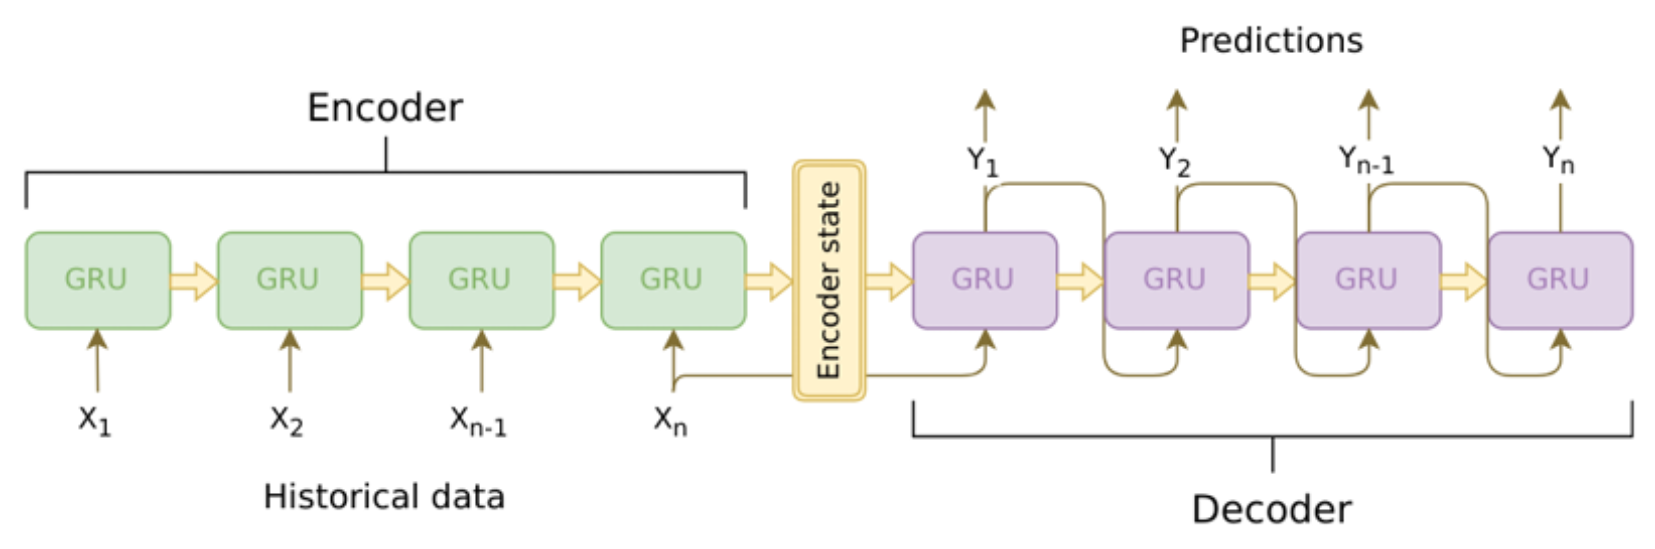
<center>Figure 6: Seq2seq network data flow.</center>

### Example - seq2seq without attention for machine translation

To understand the seq2seq model in greater detail, we will look at an example of one that learns how to translate from English to French using the French-English bilingual dataset from the Tatoeba Project (1997-2019)[26]. The dataset contains approximately 167,000 sentence pairs. To make our training fo faster, we will only consider the first 30,000 sentence pairs for our training.

In [1]:
import nltk
import numpy as np
import re
import shutil
import tensorflow as tf
import os
import unicodedata
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

The data is provided as a remote zip file. The easiest way to access the file is to download it from http://www.manythings.org/anki/fra-eng.zip and expand it locally using unzip. The zip file contains a tab separated file called **`fra.txt`**, with French and English sentence pairs separated by a tab, one pair per line. The code expects the **`fra.txt`** file in a dataset folder in the same directory as itself. We want to extract three different datasets from it.
  
  
If you recall the structure of the seq2seq network, the input to the encoder is a sequence of English words. On the decoder side, the input is a set of French words, and the output is the sequence of French words offset by 1 timestep. The following function will download the zip file, expand it, and create the datasets described before.
  
  
The input is preprocessed to "asciify" The characters, separate out specific punctuations from their neighboring word, and remove all characters other than alphabets and these specific punctuation symbols. Finally, the sentences are converted to lowercase. Each English sentence is just converted to a single sequence of words. Each French sentence is converted into two sequences, one preceded by the BOS pseudo-word and the other followed by the **end of sentence(EOS)** pseudo-word.
  
  
The first sequence starts at position 0 and stops one short of the final word in the sentence, and the second sequence starts at position 1 and goes all the way to the end of the sentence:

In [21]:
def preprocess_sentence(sent):
    sent = "".join([c for c in unicodedata.normalize("NFD", sent)
                   if unicodedata.category(c) != "Mn"])
    sent = re.sub(r"([!.?])", r" \1", sent)
    sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)
    sent = re.sub(r"\s+", " ", sent)
    sent = sent.lower()
    return sent

def download_and_read(num_sent_pairs=30000):
    en_sents, fr_sents_in, fr_sents_out = [], [], []
    local_file = os.path.join("datasets", "fra.txt")
    with open(local_file, "r", encoding='utf8') as fin:
        for i, line in enumerate(fin):
            en_sent, fr_sent, _ = line.strip().split('\t')
            en_sent = [w for w in preprocess_sentence(en_sent).split()]
            fr_sent = preprocess_sentence(fr_sent)
            fr_sent_in = [w for w in ("BOS " + fr_sent).split()]
            fr_sent_out = [w for w in (fr_sent + " EOS").split()]
            en_sents.append(en_sent)
            fr_sents_in.append(fr_sent_in)
            fr_sents_out.append(fr_sent_out)
            if i >= num_sent_pairs - 1:
                break
    return en_sents, fr_sents_in, fr_sents_out

In [22]:
sents_en, sents_fr_in, sents_fr_out = download_and_read()

In [24]:
print(type(sents_en))
print(type(sents_fr_in))
print(type(sents_fr_out))
print(len(sents_en))
print(len(sents_fr_in))
print(len(sents_fr_out))
print(sents_en[0])
print(sents_fr_in[0])
print(sents_fr_out[0])
print(sents_en[29999])
print(sents_fr_in[29999])
print(sents_fr_out[29999])

<class 'list'>
<class 'list'>
<class 'list'>
30000
30000
30000
['go', '.']
['BOS', 'va', '!']
['va', '!', 'EOS']
['i', 'm', 'a', 'little', 'hungry', '.']
['BOS', 'j', 'ai', 'un', 'peu', 'faim', '.']
['j', 'ai', 'un', 'peu', 'faim', '.', 'EOS']


Our next step is to tokenize our inputs and create the vocabulary. Since we have sequences in two different languages, we will create two different tokenizers and vocabularies, one for each language. The tf.keras framework provides a very powerful and versatile tokenizer class - here we have set filters to an empty string and lower to **`False`** because we have already done what was needed for tokenization in our **`preprocess_sentence()`** function. The Tokenizer creates various data structures from which we can compute the vocabulary sizes and lookup tables that allow us to go from word to word index and back.
  
  
Next we handle different length sequences of words by padding with zeros at the end, using the **`pad_sequences()`** function. Because our string are fairly short, we do not dn any truncation; we just pad to the maximum length of sentence that we have (8 words for English, and 16 words for French):

In [38]:
tokenizer_en = tf.keras.preprocessing.text.Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en)
data_en = tokenizer_en.texts_to_sequences(sents_en)
data_en = tf.keras.preprocessing.sequence.pad_sequences(data_en, padding='post')

In [41]:
print(type(tokenizer_en))
print(tokenizer_en)
print(type(data_en))
print(data_en.shape)
print(data_en[0], data_en[29999])

<class 'keras_preprocessing.text.Tokenizer'>
<class 'numpy.ndarray'>
(30000, 8)
[30  1  0  0  0  0  0  0] [  2  14   6 542 219   1   0   0]


In [42]:
tokenizer_fr = tf.keras.preprocessing.text.Tokenizer(filters="", lower=False)
tokenizer_fr.fit_on_texts(sents_fr_in)
tokenizer_fr.fit_on_texts(sents_fr_out)
data_fr_in = tokenizer_fr.texts_to_sequences(sents_fr_in)
data_fr_in = tf.keras.preprocessing.sequence.pad_sequences(data_fr_in, padding='post')
data_fr_out = tokenizer_fr.texts_to_sequences(sents_fr_out)
data_fr_out = tf.keras.preprocessing.sequence.pad_sequences(data_fr_out, padding='post')

In [43]:
print(type(data_fr_in))
print(data_fr_in.shape)
print(data_fr_in[0], data_fr_in[29999])
print(type(data_fr_out))
print(data_fr_out.shape)
print(data_fr_out[0], data_fr_out[29999])

<class 'numpy.ndarray'>
(30000, 16)
[ 2 86 12  0  0  0  0  0  0  0  0  0  0  0  0  0] [  2  10  13  24 156 217   1   0   0   0   0   0   0   0   0   0]
<class 'numpy.ndarray'>
(30000, 16)
[86 12  3  0  0  0  0  0  0  0  0  0  0  0  0  0] [ 10  13  24 156 217   1   3   0   0   0   0   0   0   0   0   0]


In [44]:
vocab_size_en = len(tokenizer_en.word_index)
vocab_size_fr = len(tokenizer_fr.word_index)
word2idx_en = tokenizer_en.word_index
idx2word_en = {v:k for k, v in word2idx_en.items()}
word2idx_fr = tokenizer_fr.word_index
idx2word_fr = {v:k for k, v in word2idx_fr.items()}
print('vocab size (en): {:d}, vocab size (fr): {:d}'.format(vocab_size_en, vocab_size_fr))
maxlen_en = data_en.shape[1]
maxlen_fr = data_fr_out.shape[1]
print('seqlen (en): {:d}, (fr): {:d}'.format(maxlen_en, maxlen_fr))

vocab size (en): 4348, vocab size (fr): 7573
seqlen (en): 8, (fr): 16


Finally, we convert the data to a TensorFlow dataset, then split it into a training and test dataset:

In [45]:
NUM_SENT_PAIRS = 30000
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices((data_en, data_fr_in, data_fr_out))
dataset = dataset.shuffle(10000)
test_size = NUM_SENT_PAIRS // 4
test_dataset = dataset.take(test_size).batch(batch_size, drop_remainder=True)
train_dataset = dataset.skip(test_size).batch(batch_size, drop_remainder=True)

Our data is now ready to be used for training the seq2seq network, which we will define next. Our encoder is an Embedding layer followed by a GRU layer. The input to the encoder is a sequence of integers, which is converted to a sequence of embedding vectors of size **`embedding_dim`**. This sequence of vectors is sent to an RNN, which converts the input at each of the **`num_timesteps`** time steps to a vector of size **`encoder_dim`**. Only the output at the last time step is returned, as shown by the **`return_sequences=False`**. The decoder has almost the same structure as the encoder, except that is has an additional Dense layer that converts the vector of size **`decoder_dim`** that is output from the RNN, into a vector that represents the probability distribution across the target vocabulary. The decoder also returns outputs along al its time steps.
  
  
In our example network, we have chosen our embedding dimension to be 128, followed by the encoder and decoder RNN dimension of 1024 of 1024 each. Note that we have to add 1 to the vocabulary size for both the English and French vocabularies to account for the PAD character that was added during the **`pad_sequences()`** step:

In [46]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, num_timesteps, embedding_dim, encoder_dim, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.encoder_dim = encoder_dim
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=num_timesteps)
        self.rnn = tf.keras.layers.GRU(encoder_dim, return_sequences=False, return_state=True)
        
    def call(self, x, state):
        x = self.embedding(x)
        x, state = self.rnn(x, initial_state=state)
        return x, state
        
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.encoder_dim))

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, num_timesteps, decoder_dim, **kwargs):
        super(Decoder, self).__init__(*kwargs)
        self.decoder_dim = decoder_dim
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=num_timesteps)
        self.rnn = tf.keras.layers.GRU(decoder_dim, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x, state):
        x = self.embedding(x)
        x, state = self.rnn(x, state)
        x = self.dense(x)
        return x, state

In [47]:
embedding_dim = 256
encoder_dim, decoder_dim = 1024, 1024
encoder = Encoder(vocab_size_en + 1, embedding_dim, maxlen_en, encoder_dim)
decoder = Decoder(vocab_size_fr + 1, embedding_dim, maxlen_fr, decoder_dim)

Now that we  have define our Encoder and Decoder classes, let us revisit the dimensions of their inputs and outputs. The following piece of (throwaway) code can be used to print out the dimensions of the various inputs and outputs of the system. It has been left in for convenience as a commented out black in the code supplied with this chapter:

In [48]:
for encoder_in, decoder_in, decoder_out in train_dataset:
    encoder_state = encoder.init_state(batch_size)
    encoder_out, encoder_state = encoder(encoder_in, encoder_state)
    decoder_state = encoder_state
    decoder_pred, decoder_state = decoder(decoder_in, decoder_state)
    break
print("encoder input : ", encoder_in.shape)
print("encoder output : ", encoder_out.shape, "state:", encoder_state.shape)
print("decoder output (logits):", decoder_pred.shape, "state:", decoder_state.shape)
print("decoder output (labels):", decoder_out.shape)

encoder input :  (64, 8)
encoder output :  (64, 1024) state: (64, 1024)
decoder output (logits): (64, 16, 7574) state: (64, 1024)
decoder output (labels): (64, 16)


This produces the above output, which is in line with our expectations. The encoder input is a batch of a sequence of integers, each sequence being of size 8, which is the maximum number of tokens in our English sentences, so its dimension is (**`batch_size`**, **`maxlen_en`**).
  
  
The output of the encoder is a single tensor (**`return_sequences=False`**) of shape (**`batch_size, encoder_dim`**) and represents a batch of context vectors representing the input sentences. The encoder state tensor has the same dimensions. The decoder outputs are also a batch of sequence of integers, but the maximum size of a French sentence is 16; therefore, the dimensions are (**`batch_size`**, **`maxlen_fr`**). The decoder predictions are a batch of probability distributions across all time steps; hence the dimensions are (**`batch_size`**, **`maxlen_fr`**, **`vocab_size_fr+1`**), and the decoder state is the same dimension as the encoder state (**`batch_size`**, **`decoder_dim`**)

Next we define the loss function. Because we padded our sentences, we don't want to bias our results by considering equality of pad words between the labels and predictions. Our loss function masks our predictions with the labels, so padded positions on the label are also removed from the predictions, and we only compute our loss using the non zero elements on both the label and predictions. This is done as follows:

In [49]:
def loss_fn(ytrue, ypred):
    scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    mask = tf.math.logical_not(tf.math.equal(ytrue, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    loss = scce(ytrue, ypred, sample_weight=mask)
    return loss

Because the seq2seq model is not easy to package into a simple Keras model, we have to handle the training loop manually as well. Our **`train_step()`** function handles the flow of data and computes the loss at each step, applies the gradient of the loss back to the trainable weights, and return the loss. 
  
  
Notice that the training code is not quite the same as what was described in our discussion of the seq2seq model earlier. Here it appears that the entire **`decoder_input`** is fed in one go into t he decoder to produce the output offset bt one time step, whereas in the discussion, we said that this happens sequentially, where the token generated in the previous time step is used as the input to the next time step.
  
  
This is a common technique used to train seq2seq networks, which is called **Teacher Forcing**, where the input to the decoder is the ground truth output instead of the prediction from the previous time step. This is preferred because it makes training faster, but also results in some degradation in prediction quality. To offset this, techniques such as **scheduled Sampling** can be used, where the input is sampled randomly either from the ground truth or the prediction at the previous time step, based on some threshold (depends on the problem, but usually varies between 0.1 and 0.4):